<a href="https://colab.research.google.com/github/Beh-noush/TT-classification/blob/main/TN_classification_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****We will adjust this code for the case of multi-class classification. That is, the function 'make_tensor' wont use the command 'tl.tt_to_tensor' or 'tl.cp_to_tensor' any more. 

In [1]:
import pickle
import string
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import math
from torch import einsum
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
torch.manual_seed(0)

torch.cuda.is_available()

if torch.cuda.is_available:
  dev = 'cuda:0'
else:
  dev = 'CPU'

device = torch.device(dev)

from tqdm import tqdm
!pip install tensorly
import tensorly as tl
tl.set_backend('pytorch')

     |████████████████████████████████| 198 kB 5.4 MB/s 
     |████████████████████████████████| 154 kB 36.0 MB/s 


In [2]:
def unit(A,B):
  return(torch.einsum('ij, ik -> ijk', A,B))

In [27]:
def make_tensor(core_tensors, decompos):
  """
  computes the tensor made up of "core_tensors" according to a given tensor decomposition, "decompos".
  
  Parameters
  -------
  core_tensors: list
               list of cores of the corresponding tensor decomposition.
  
  decomposition: str
                the name of a decomposition. Ex, CP, Tucker, TT, etc.
  Returns
  ------
  tensor
    Tensor made up of core tensors.
  """
  if decompos == 'TT':
    W = tl.tt_to_tensor(core_tensors)
  if decompos == 'CP':
    rank = core_tensors[0].shape[1]
    dev = core_tensors[0].device
    W = tl.cp_to_tensor((torch.ones(rank).to(dev),core_tensors))
  if decompos == 'HT':
    W = ht_to_tensor_top_buttom(core_tensors)
  return W

In [4]:
def inner_product(data_tensor, weight_tensor):
  """
  Computes the inner products  between a batch of tensors and a weight tensor

  Parameters
  -------
  data_tensor: torch tensor
               batch of input tensors of size n x d_1 x ... x d_p
  weight_tensor: torch tensor
               tensor of order p, the weight tensor of the model.

  Returns
  ------
  vector
    Vector of size n containing the inner products 
  """
  return torch.matmul(data_tensor.reshape([data_tensor.shape[0],-1]),weight_tensor.ravel())

In [5]:
def ht_to_tensor_top_buttom(core_tensors):
  """
  computes the tensor made up of "core_tensors" according to binary hierarchical Tucker decomposition".
  
  Parameters
  -------
  core_tensors: list
               list of cores of the HT decomposition in this order: [[root], [[ Level 2], [ Level 3] , .... , [Leaves] ] ]
  
  Returns
  ------
  tensor
    Tensor made up of core tensors.
  """
  root = core_tensors[0]
  interior_levels = core_tensors[1] #interior_levels includes all levels but the first one containing the root.

  tree = root[0]
  for cores in interior_levels: 
    num_cores = len(cores)  
 #   assert num_cores == 2**(l+1), "!!!!"
    for n in range(0,num_cores,2):
      core_1, core_2 = cores[n] , cores[n+1]
      tree = torch.einsum('i..., ijk -> ...jk', tree, unit(core_1, core_2))

  return tree

In [6]:
def check(core_tensors):
  root = core_tensors[0]
  interior_levels = core_tensors[1] #interior_levels includes all levels but the first one containing the root.
  level_2 = interior_levels[0]
  level_3 = interior_levels[1]
  level_4 = interior_levels[2]
  tree = root[0]
  tree = torch.einsum('i, ijk -> jk', tree, unit(level_2[0], level_2[1]))
  tree = torch.einsum('ij, imn, jpq -> mnpq', tree, unit(level_3[0], level_3[1]), unit(level_3[2], level_3[3]))
  tree = torch.einsum('ijkl, imn, jpq, kst, lyz -> mnpqstyz', tree, unit(level_4[0], level_4[1]), unit(level_4[2], level_4[3]), unit(level_4[4], level_4[5]), unit(level_4[6], level_4[7]))

  return tree

In [6]:
class HTModel_top_buttom(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a (binary) HT tensor.
    """
    def __init__(self, order, dimension, rank, task = 'classification' ,init='normal'): 
        """
        Parameters
        ---------
        order: int
          order of the tensor, i.e., the number of free legs
        dimension: int
          Uniform dimension of the HT tensor 
        rank: int
          Uniform rank of the the HT tensor
        init: string
          initialization method for the core tensors of the HT parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order , dimension, rank
        self.num_layers = int(math.log(self.order, 2) + 1)

        self.weight_root = [nn.Parameter(torch.Tensor(self.bond))]
        self.int_layers = [None for i in range(self.num_layers-1)] #This includes all layer but the one containing the root.

        self.int_layers[-1] = [nn.Parameter(torch.Tensor( self.bond, self.dim)) for i in range(self.order)] #This gives the leaves of the tree.

        for i in range(1,self.num_layers-1):  #This includes all L-2 interior layers.
          self.int_layers[i-1] = [nn.Parameter(torch.Tensor(self.bond, self.bond)) for k in range(2**i)]

        self.params = nn.ParameterList( self.weight_root + [item for level in self.int_layers for item in level]) 

        self.nested_weights = [ self.weight_root, self.int_layers] # This variable is defined to have a nested list for doing contractions in forward function.


        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        ht_weight = make_tensor(self.nested_weights, 'HT')    #This line refers to the above-defined function 'ht_to_tensor_top_buttom' through the function 'make_tensor'.
        prod = inner_product(x, ht_weight)
        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b  
        if task == 'regression':
          return prod#.view(-1,1)     



In [ ]:
my_ht = HTModel_top_buttom(8,3,2)
a = check(my_ht.nested_weights) == ht_to_tensor_top_buttom(my_ht.nested_weights)
False in a

In [7]:
class CPModel(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a CP tensor 
    """
    def __init__(self, order, dimension, rank, task = 'classification', init='normal'): 
        """
        Parameters
        ---------
        order: int
          Order of the CP tensor
        dimension: int
          Uniform dimension of the CP tensor 
        rank: int
          Uniform rank of the the CP tensor
        init: string
          initialization method for the core tensors of the CP parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order, dimension, rank

        self.weights = [nn.Parameter(torch.Tensor(self.dim, self.bond)) for i in range(self.order)]

        self.params = nn.ParameterList(self.weights)

        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        cp_weight = make_tensor(self.weights, 'CP')
        prod = inner_product(x, cp_weight)
        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b    
        if task == 'regression':
          return prod#.view(-1,1)



In [8]:
class TTModel(nn.Module):      
    """ 
    Class for a linear binary classifier parameterized by a TT tensor 
    """
    def __init__(self, order, dimension, rank, task = 'classification', init='normal'): 
        """
        Parameters
        ---------
        order: int
          Order of the TT tensor
        dimension: int
          Uniform dimension of the the TT tensor 
        rank: int
          Uniform rank of the the TT tensor
        init: string
          initialization method for the core tensors of the TT parameters
          choices are "uniform" and "normal"
        """
        super().__init__()
        self.order, self.dim, self.bond = order, dimension, rank

        cores = [None for i in range(self.order)]
        self.weights = [None for i in range(self.order)]
        cores[0] = torch.Tensor(1,self.dim, self.bond)
        for l in range(1,self.order-1):
          cores[l] = torch.Tensor(self.bond, self.dim, self.bond)
        cores[-1] = torch.Tensor(self.bond, self.dim,1)
        for l in range(self.order):
          self.weights[l] = nn.Parameter(cores[l])
        self.params = nn.ParameterList(self.weights)

        # initialize weights and biases
        for weight in self.params:
          if init=='normal':
            torch.nn.init.normal_( weight, mean=0.0, std= .5)
          elif init=='uniform':
            torch.nn.init.uniform_(weight,-1,1)

    def forward(self, x): 
        """
        Computes the forward pass

        Parameters
        ---------
        self

        x: Batches of n input tensors of order [order]
            
        Returns
        ------
        (for the classification task) torch tensor of shape [n,2]
          Tensor containing the scores of each input for the two classes

        (for the regression task) torch tensor of shape[n]
          containing the predicted real value of each input data
    
        """
        TT_weight = make_tensor(self.weights, 'TT')
        prod = inner_product(x, TT_weight)
#        return torch.stack((prod,-1*prod),0).T  # w times x + b       

        if task == 'classification':
          return torch.stack((prod,-1*prod),0).T  # w times x + b    
        if task == 'regression':
          return prod#.view(-1,1)


In [9]:
#First, we define a function to produce the examples.
#To make analogy with Cohen et al.'s work, we make the data tensor as a tensor product (rank-1).
import string
list_of_letters = list(string.ascii_letters)
def make_inputs(size, order, dimension):
  '''
  provides a batch of input tensorial data

  Parameters
  -----------
  size: int
        the batch size
  order: int
         the order of each tensor in the batch
  dimension: int
         the dimension of the tensor along all its modes 

  Returns
  -----------
     a rank-1 tensor of shape [size, dimension, dimension , ...., dimension] (a tensor of order [1+order])
     
  '''
  string_einsum_left =''
  string_einsum_right =''

  for o in range(order-1):
    string_einsum_left += list_of_letters[o]+','
    string_einsum_right += list_of_letters[o]

  string_einsum_left += list_of_letters[order-1] 
  string_einsum_right += list_of_letters[order-1] 

  einsum_prod = string_einsum_left + '->' + string_einsum_right
  list_data_tensors = []
  for j in range(size):
    data_vecs = [torch.randn(dimension) for i in range(order)]
    data_tensor = torch.einsum(einsum_prod , data_vecs) #This line outputs a rank-1 tensor of order [order] by doing an einsum operation of type ('i,j,...,k -> ij...k')
    list_data_tensors.append(data_tensor)
  data = torch.stack(list_data_tensors) #Here, the out put is a tensor of order [order + 1].
  return data

def make_labels(inputs, oracle, order,dimension,target_rank, task, init):
  '''
  provides a batch of labels.

  Parameters:
  ------------
  inputs: tensor of shape [batch_size, dimension, ... ,dimension] of order [order+1]

  oracle: string
          the name of the target model which is a tensor network (either CP, or TT, or HT)

  order: int
         the order of the tensors in the variable 'inputs' which should be less than the order of 'inputs' by 1. (inputs is a batch of tensors)
 
  dimension: int
         the dimension of the tensors in inputs along the modes

  target_rank: int
         the rank of the oracle, which is a tensor network.

  task: string
         either classification, or regression

  init: string
        the initialization of the parameters of the oracle tensor network (either 'uniform' or 'normal')


  Returns:
  ------------
      a tensor of size [batch_size] containing the labels assigned to the variable 'inputs' according to the oracle.
  '''
  #First, do some dimension checks, the dimensionality of inputs should match the function variables, order and dimension!
  if len(inputs.shape) != (order + 1) or inputs.shape[1] != dimension:
    print('Model dimension not compatible with the input size!')
  if oracle == 'HT':
    target_model = HTModel_top_buttom(order,dimension,target_rank,task = task,init='normal')
  if oracle == 'CP':
    target_model = CPModel(order,dimension,target_rank, task = task, init='normal')
  if oracle == 'TT':
    target_model = TTModel(order,dimension,target_rank, task = task, init='normal')
 # test_inputs = make_inputs(test_size, order, dimension)#torch.randn([test_size] + [dimension]*order)
  if task == 'classification':
    _,test_labels = torch.max(target_model.forward(inputs),axis=1)
  if task == 'regression':
    test_labels = target_model.forward(inputs).detach_() #.detach_() added to fix an error with the computational graph.
  return test_labels

# train = data_utils.TensorDataset(test_inputs, test_labels)

def make_dataset(inputs, labels):
  '''
  provides a torch dataset

  Parameters:
  ----------

  inputs: torch tensor
       a tensor of shape [batch_size, dimension, ... ,dimension]


  labels: torch tensor
       a tensor of shape [batch_size]
  Returns:
  ------------
  a torch dataset with inputs as features and labels as their corresponding labels.
  '''
  if inputs.shape[0] != labels.shape[0]:
    print('inputs and labels of inconsistent size!')
  return data_utils.TensorDataset(inputs,labels)

In [76]:
class TNlearner():
  def __init__(self, batch_size, order, dimension, oracle, target_rank, init, device , seed):
    self.batch_size, self.order, self.dimension, self.target_rank, self.oracle, self.task, self.init = batch_size, order, dimension, target_rank,oracle,task,init
    self.device = device
    self.seed = seed
  def data_loader(self,size):
    torch.manual_seed(seed) #Is this a good idea to produce same samplesfor the same oracle?
    train_input = make_inputs(size, self.order, self.dimension)
    train_label = make_labels(train_input, self.oracle , self.order, self.dimension, self.target_rank, self.task , self.init)
    self.train_dataset = make_dataset(train_input, train_label)
    return data_utils.DataLoader(self.train_dataset, self.batch_size, shuffle=True)    

  def make_loaders(self, sample_size, test_size):
    train_loader = self.data_loader(sample_size)
    test_loader = self.data_loader(test_size)    
    return {'train': train_loader, 'valid':test_loader}

  def train_model(self, sample_size, test_size, model_rank, optimizer, lr, epochs, model_name, every_n_epochs , epochs_saved = False , init_model='normal'): #Delete loss_func!
    """
    Trains a TT or HT or CP classifier and returns the trained model.

    Parameters
    --------
    sample_size: int
          training sample size
    
    test_size: int
          test sample size

    data_loaders: dict of two dataloaders, with keys 'train' and 'valid'. dataloaders = {'train':training_data, 'valid': valid_data}
                  
    model_rank: int
          the model's rank
    optimizer:
          pytorch optimizer 
    lr: float
          learning rate
    epochs: int
          number of learning epochs
    model_name: str
          the name of the tensor decomposition model, Eg., CP, TT, etc
    every_n_epochs: int
          at what number of epochs to save results?
    epochs_saved: Boolean
          Whether or not to save the training losses over epochs, we put it True, if we are concerned with the convergence of the loss plots.
    init: str
          which initialization we take for the weights of the to-be-trained model.
    Returns
    ------
      Trained model
        
    """
    data_loader = self.make_loaders(sample_size, test_size)
    train_losses = []
    train_accs=[]
    test_losses = []
    test_accs = []
    dict_res = {'losses':{'train': train_losses, 'valid':test_losses}, 'accuracies': {'train':train_accs, 'valid': test_accs} }
    num_samples = {'train': sample_size, 'valid': test_size}
    num_samples = {'train': 500, 'valid': 200}
    if model_name == 'TT':
      model = TTModel(self.order, self.dimension, model_rank, self.task, init= init_model)#.to(device) Note that before, I had forgotten to write "task" as an argument for TTModel, CPModel and HTModel.
    if model_name == 'CP':
      model = CPModel(self.order, self.dimension, model_rank, self.task, init= init_model)#.to(device)
    if model_name == 'HT':
      model = HTModel_top_buttom(self.order, self.dimension, model_rank, self.task, init= init)#.to(device)
    model = model.to(self.device)
    if self.task == 'classification':
      loss_func = nn.CrossEntropyLoss()
    if self.task == 'regression':
      loss_func = nn.MSELoss()
    optimizer = optimizer(model.parameters(), lr)
    for e in range(epochs):  
      for mode in ['train','valid']:
        loss_epoch = 0
        acc_epoch = 0     
        if mode == 'train':
          model.train()
        else:
          model.eval()
        for data, label in data_loader[mode]:
          data = data.to(self.device)
          label = label.to(self.device)
          model_output = model.forward(data)#.detach_() #Meraj's trick
          loss = loss_func(model_output, label)

          if self.task == 'classification':
            pred = torch.argmax(model_output, axis = 1)
            acc = torch.sum((pred == label).float())
            acc_epoch += acc/num_samples[mode]

          loss_epoch += loss
          if mode == 'train':
            loss.backward()#(retain_graph= True)
            optimizer.step()
            optimizer.zero_grad()
        if epochs_saved == True and e%every_n_epochs == 0:
          dict_res['losses'][mode].append(loss_epoch)
          if self.task == 'classification':
            dict_res['accuracies'][mode].append(acc_epoch)
    results = {'trained_model': model, #'train_loss': train_losses, 'train_acc': train_accs, 'test:loss': test_losses, 'test_acc': test_accs, 
                    'model_params':{'rank':model_rank, 'loss_func':loss_func, 'optimizer':optimizer, 'lr':lr, 'epochs':epochs, 'model_name':model_name, 'task':self.task, 'init':init}}

    return (results, dict_res) #epoch_losses to add


In [60]:
dict_res = {'CP' : {}, 'HT': {}}

In [79]:
train_size=500
batch_size = 10
test_size = 200
lr = .00001
epochs= 300
task = 'regression'
dimension = 4
order = 4
target_rank = 8
model_rank = 6
oracle ='CP'
init = 'uniform'
device = 'cuda:0'
model_name_list= ['HT','CP']
rank_list = [2,4,6,8]
seed = 0
TNclass= TNlearner(batch_size, order, dimension, oracle, target_rank, init, device, seed)
for model_name in model_name_list:
  for model_rank in rank_list:
    _, dict_res[model_name][model_rank] = TNclass.train_model(train_size, test_size, model_rank, optim.SGD, lr , epochs, model_name, every_n_epochs= 10, epochs_saved=True, init_model='uniform')

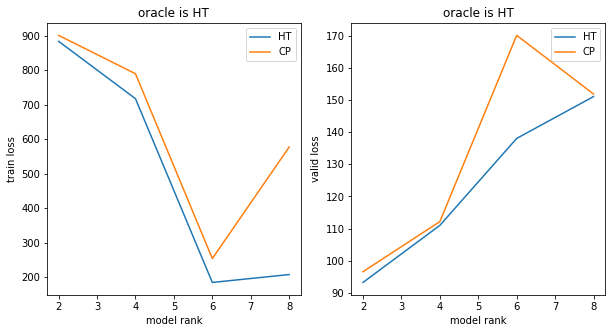

In [86]:
#list of final epoch's loss for model HT
modes = ['train', 'valid']
loss_list_rank = {'CP': {'train' : None , 'valid': None}  , 'HT': {'train' :None  , 'valid':None } }
for model in model_name_list:
  for mode in modes:
    loss_list_rank[model][mode] =  [ dict_res[model][model_rank]['losses'][mode][-1].cpu().detach().numpy() for model_rank in rank_list]

plt.figure(figsize=(10,5))
for i in range(1,3):
  plt.subplot(1,2,i)
  plt.plot(rank_list, loss_list_rank['HT'][modes[i-1]], label = 'HT')
  plt.plot(rank_list, loss_list_rank['CP'][modes[i-1]], label = 'CP')
  plt.legend()
  plt.xlabel('model rank')
  plt.ylabel(f'{modes[i-1]} loss')
  plt.title(f'oracle is {oracle}')


#From here on, under construction.

##To experiment with HT vs. CP:


__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
def plot_regression_CP_vs_HT(results_CP, results_HT, train_sample_sizes,  oracle, target_rank, ranks, learning_rate, n_runs):
  train_loss_CP = {}
  train_loss_HT = {}
  test_loss_CP = {}
  test_loss_HT = {}
  gen_gaps_CP = {}
  gen_gaps_HT = {}
  with sns.axes_style('darkgrid'):
    colors = sns.color_palette('husl' , 2)
    figure = plt.figure(figsize=(20, 4))
    c = 0
    for sample_size in train_sample_sizes:
      #First, training loss
      train_loss_CP[sample_size] = np.array([[((losses[1]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_tr_loss_CP = np.mean(train_loss_CP[sample_size], axis = 0) 
      stds_tr_loss_CP = np.std(train_loss_CP[sample_size], axis = 0)

      train_loss_HT[sample_size] = np.array([[((losses[1]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_tr_loss_HT = np.mean(train_loss_HT[sample_size], axis = 0) 
      stds_tr_loss_HT = np.std(train_loss_HT[sample_size], axis = 0)
      plt.xlabel('rank')
      plt.subplot(1, 3, 1)
      plt.title(f'target model = {oracle} with rank {target_rank}, lr = {learning_rate}')

      plt.ylabel('training loss')
    # plt.yscale('log')
      plt.plot(ranks, ys_tr_loss_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_tr_loss_CP) - torch.tensor(stds_tr_loss_HT)) , list(torch.tensor(ys_tr_loss_CP) + torch.tensor(stds_tr_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
  #   plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
      c+=1
      plt.plot(ranks, ys_tr_loss_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_tr_loss_HT) - torch.tensor(stds_tr_loss_HT)) , list(torch.tensor(ys_tr_loss_HT) + torch.tensor(stds_tr_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()

    #Secondly, test loss.
  
      test_loss_CP[sample_size] = np.array([[((losses[2]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_test_loss_CP = np.mean(test_loss_CP[sample_size], axis = 0) 
      stds_test_loss_CP = np.std(test_loss_CP[sample_size], axis = 0)

      test_loss_HT[sample_size] = np.array([[((losses[2]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_test_loss_HT = np.mean(test_loss_HT[sample_size], axis = 0) 
      stds_test_loss_HT = np.std(test_loss_HT[sample_size], axis = 0)
      plt.subplot(1, 3, 2)

      plt.title(f'n = {train_sample_sizes[0]}, #run = {n_runs}')

      plt.ylabel('test loss')
    #  plt.yscale('log')
      plt.plot(ranks, ys_test_loss_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_test_loss_CP) - torch.tensor(stds_test_loss_CP)) , list(torch.tensor(ys_test_loss_CP) + torch.tensor(stds_test_loss_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c+=1
      plt.plot(ranks, ys_test_loss_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_test_loss_HT) - torch.tensor(stds_test_loss_HT)) , list(torch.tensor(ys_test_loss_HT) + torch.tensor(stds_test_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()

      # Third, generalization error.
      gen_gaps_CP[sample_size] = np.array([[((losses[2] - losses[1]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_gen_CP = np.mean(gen_gaps_CP[sample_size], axis = 0) 
      stds_gen_CP = np.std(gen_gaps_CP[sample_size], axis = 0)

      gen_gaps_HT[sample_size] = np.array([[((losses[2] - losses[1]).detach()) for losses in result[sample_size]] for result in results_HT])
      # n_params = order*dimension
      # upper_bound[sample_size] = np.array( [2*(np.sqrt( n_params*rank**2*math.log(8*sample_size*order*np.e / (n_params*rank**2))/sample_size))  for rank in ranks])
      ys_gen_HT = np.mean(gen_gaps_HT[sample_size], axis = 0) 
      stds_gen_HT = np.std(gen_gaps_HT[sample_size], axis = 0)
      
      plt.subplot(1,3,3)

      plt.title(f'number of epochs = {epochs}')
      plt.ylabel('generalization error')
    #  plt.yscale('log')
      plt.plot(ranks, ys_gen_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_gen_CP) - torch.tensor(stds_gen_CP)) , list(torch.tensor(ys_gen_CP) + torch.tensor(stds_gen_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
  #   plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
      c+=1
      plt.plot(ranks, ys_gen_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_gen_HT) - torch.tensor(stds_gen_HT)) , list(torch.tensor(ys_gen_HT) + torch.tensor(stds_gen_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()

      plt.legend()

In [ ]:
def plot_CP_vs_HT(results_CP, results_HT, train_sample_sizes,  oracle, target_rank, ranks, learning_rate):

  train_loss_CP = {}
  train_loss_HT = {}
  test_loss_CP = {}
  test_loss_HT = {}
  gen_gaps_CP = {}
  gen_gaps_HT = {}
  test_acc_CP = {}
  test_acc_HT = {}
  train_acc_CP = {}
  train_acc_HT = {}
  with sns.axes_style('darkgrid'):
    colors = sns.color_palette('husl' , 2)
    figure = plt.figure(figsize=(20, 4))
    c = 0
    for sample_size in train_sample_sizes:
      #First, training loss
      train_loss_CP[sample_size] = np.array([[((losses[1]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_tr_loss_CP = np.mean(train_loss_CP[sample_size], axis = 0) 
      stds_tr_loss_CP = np.std(train_loss_CP[sample_size], axis = 0)

      train_loss_HT[sample_size] = np.array([[((losses[1]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_tr_loss_HT = np.mean(train_loss_HT[sample_size], axis = 0) 
      stds_tr_loss_HT = np.std(train_loss_HT[sample_size], axis = 0)
      plt.xlabel('rank')
      plt.subplot(1, 5, 1)
      plt.title(f'target model = {oracle} with rank {target_rank}, , lr = {learning_rate}')

      plt.ylabel('training loss')
    # plt.yscale('log')
      plt.plot(ranks, ys_tr_loss_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_tr_loss_CP) - torch.tensor(stds_tr_loss_HT)) , list(torch.tensor(ys_tr_loss_CP) + torch.tensor(stds_tr_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
  #   plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
      c+=1
      plt.plot(ranks, ys_tr_loss_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_tr_loss_HT) - torch.tensor(stds_tr_loss_HT)) , list(torch.tensor(ys_tr_loss_HT) + torch.tensor(stds_tr_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()

    #Secondly, test loss.
  
      test_loss_CP[sample_size] = np.array([[((losses[2]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_test_loss_CP = np.mean(test_loss_CP[sample_size], axis = 0) 
      stds_test_loss_CP = np.std(test_loss_CP[sample_size], axis = 0)

      test_loss_HT[sample_size] = np.array([[((losses[2]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_test_loss_HT = np.mean(test_loss_HT[sample_size], axis = 0) 
      stds_test_loss_HT = np.std(test_loss_HT[sample_size], axis = 0)
      plt.subplot(1, 5, 2)

      plt.title(f'n = {train_sample_sizes[0]}')

      plt.ylabel('test loss')
    #  plt.yscale('log')
      plt.plot(ranks, ys_test_loss_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_test_loss_CP) - torch.tensor(stds_test_loss_CP)) , list(torch.tensor(ys_test_loss_CP) + torch.tensor(stds_test_loss_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c+=1
      plt.plot(ranks, ys_test_loss_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_test_loss_HT) - torch.tensor(stds_test_loss_HT)) , list(torch.tensor(ys_test_loss_HT) + torch.tensor(stds_test_loss_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()

      #Third, test accuracy.

      test_acc_CP[sample_size] = np.array([[((losses[3]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_test_acc_CP = np.mean(test_acc_CP[sample_size], axis = 0) 
      stds_test_acc_CP = np.std(test_acc_CP[sample_size], axis = 0)

      test_acc_HT[sample_size] = np.array([[((losses[3]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_test_acc_HT = np.mean(test_acc_HT[sample_size], axis = 0) 
      stds_test_acc_HT = np.std(test_acc_HT[sample_size], axis = 0)
      plt.subplot(1, 5, 3)
      plt.title(f'order = {order}, dimension = {dimension}')

      plt.xlabel('rank')
      plt.ylabel('test accuracy')
      plt.yscale('log')
      plt.plot(ranks, ys_test_acc_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_test_acc_CP) - torch.tensor(stds_test_acc_CP)) , list(torch.tensor(ys_test_acc_CP) + torch.tensor(stds_test_acc_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c+=1
      plt.plot(ranks, ys_test_acc_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_test_acc_HT) - torch.tensor(stds_test_acc_HT)) , list(torch.tensor(ys_test_acc_HT) + torch.tensor(stds_test_acc_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()
      #Fourth, train accuracy.

      train_acc_CP[sample_size] = np.array([[((losses[4]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_train_acc_CP = np.mean(train_acc_CP[sample_size], axis = 0) 
      stds_train_acc_CP = np.std(train_acc_CP[sample_size], axis = 0)

      train_acc_HT[sample_size] = np.array([[((losses[4]).detach()) for losses in result[sample_size]] for result in results_HT])
      ys_train_acc_HT = np.mean(train_acc_HT[sample_size], axis = 0) 
      stds_train_acc_HT = np.std(train_acc_HT[sample_size], axis = 0)
      plt.subplot(1, 5, 4)
      plt.title(f'test size = {test_size}')

      plt.xlabel('rank')
      plt.ylabel('train accuracy')
      plt.yscale('log')
      plt.plot(ranks, ys_train_acc_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_train_acc_CP) - torch.tensor(stds_train_acc_CP)) , list(torch.tensor(ys_train_acc_CP) + torch.tensor(stds_train_acc_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c+=1
      plt.plot(ranks, ys_train_acc_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_train_acc_HT) - torch.tensor(stds_train_acc_HT)) , list(torch.tensor(ys_train_acc_HT) + torch.tensor(stds_train_acc_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()
      plt.legend()  
          
      # Fifth, generalization error.

      gen_gaps_CP[sample_size] = np.array([[((losses[2] - losses[1]).detach()) for losses in result[sample_size]] for result in results_CP])
      ys_gen_CP = np.mean(gen_gaps_CP[sample_size], axis = 0) 
      stds_gen_CP = np.std(gen_gaps_CP[sample_size], axis = 0)

      gen_gaps_HT[sample_size] = np.array([[((losses[2] - losses[1]).detach()) for losses in result[sample_size]] for result in results_HT])
      # n_params = order*dimension
      # upper_bound[sample_size] = np.array( [2*(np.sqrt( n_params*rank**2*math.log(8*sample_size*order*np.e / (n_params*rank**2))/sample_size))  for rank in ranks])
      ys_gen_HT = np.mean(gen_gaps_HT[sample_size], axis = 0) 
      stds_gen_HT = np.std(gen_gaps_HT[sample_size], axis = 0)
      
      plt.subplot(1,5,5)

      plt.title(f'number of epochs = {epochs}')
      plt.ylabel('generalization error')
    #  plt.yscale('log')
      plt.plot(ranks, ys_gen_CP, color = colors[c]  , label ='CP')
      plt.fill_between(ranks, list(torch.tensor(ys_gen_CP) - torch.tensor(stds_gen_CP)) , list(torch.tensor(ys_gen_CP) + torch.tensor(stds_gen_CP)), alpha = .3, facecolor = colors[c], label='_nolegend_')
  #   plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
      c+=1
      plt.plot(ranks, ys_gen_HT, color = colors[c]  , label ='HT')
      plt.fill_between(ranks, list(torch.tensor(ys_gen_HT) - torch.tensor(stds_gen_HT)) , list(torch.tensor(ys_gen_HT) + torch.tensor(stds_gen_HT)), alpha = .3, facecolor = colors[c], label='_nolegend_')
      c-=1
      plt.tight_layout()

      plt.legend()
      

##The experiment in our paper:

In [ ]:
dimension = 4
order = 4
target_rank = 8
test_size = 4000
n_runs = 20
train_sample_sizes = [2000, 4000]
ranks = [2, 4, 6 , 8 , 10, 12, 14]
learning_rate = 0.01
epochs = 1000
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD

target_model = HTModel(order,dimension,target_rank,init='uniform')
test_inputs = torch.randn([test_size] + [dimension]*order)
test_labels = torch.argmax(target_model.forward(test_inputs),axis=1)


results = []
for n in range(n_runs):
  result = {}
  for sample_size in train_sample_sizes:
    result[sample_size] = []
    for rank in ranks:
      # generate training data
      inputs = torch.randn([sample_size] + [dimension]*order)
      labels = torch.argmax(target_model.forward(inputs), axis = 1)
      # train the model
      model = train_TT_model((inputs, labels), rank, loss, optimizer, lr=learning_rate, epochs=epochs)
      test_loss = loss(model.forward(test_inputs), test_labels)
      train_loss = loss(model.forward(inputs), labels)
      result[sample_size].append((sample_size,train_loss,test_loss))
  results.append(result)        

  

### Plotting the results

[0.00640478 0.02303103 0.03646769 0.05027365 0.07151561 0.08757969
 0.10857521]
[0.00557374 0.01454905 0.01445679 0.02332144 0.02879337 0.03536797
 0.03862754]


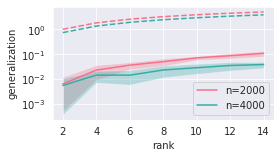

In [ ]:
log_gen_gaps = {}
upper_bound = {}
with sns.axes_style('darkgrid'):
  colors = sns.color_palette('husl' , 2)
  figure = plt.figure(figsize=(4,2.3))
  c = 0
  for sample_size in train_sample_sizes:
    log_gen_gaps[sample_size] = np.array([[((losses[2]-losses[1]).detach()) for losses in result[sample_size]] for result in results])
    n_params = order*dimension
    upper_bound[sample_size] = np.array( [2*(np.sqrt( n_params*rank**2*math.log(8*sample_size*order*np.e / (n_params*rank**2))/sample_size))  for rank in ranks])
    ys = np.mean(log_gen_gaps[sample_size], axis = 0) 
    stds = np.std(log_gen_gaps[sample_size], axis = 0)
    print(ys)
    plt.xlabel('rank')
    plt.ylabel('generalization')
    plt.yscale('log')
    plt.plot(ranks, ys, color = colors[c]  , label ='experiment')
    plt.fill_between(ranks, list(torch.tensor(ys) - torch.tensor(stds)) , list(torch.tensor(ys) + torch.tensor(stds)), alpha = .3, facecolor = colors[c], label='_nolegend_')
    plt.plot(ranks,list(torch.tensor(upper_bound[sample_size])), color = colors[c] , linestyle ='dashed', label='_nolegend_') # The factor 1/4 is to reduce the distance between the bound curve from the theory and the one from our experiment.
    c+=1
    plt.tight_layout()

  plt.legend("n=2000 n=4000".split())